# Well-Mixed Reaction System

<div class="admonition note">
**Topics**: Model declaration, context managers, reaction declaration, simulation paths, data saving, data access.
</div>

In this chapter, we’ll use some simple classical reaction systems as examples to introduce the basics of using STEPS. More specifically, we’ll focus on reaction systems that occur in a single, well-mixed reaction volume. The topics presented in later chapters (such as surface-volume interactions, diffusion, 3D environments, etc) will build on the material presented in this chapter.

In our first STEPS simulation, we'll be working with the following simple system,
which consists of a single reversible reaction:

\begin{equation}
A+B\underset{{k_{b}}}{\overset{{k_{f}}}{{\rightleftarrows}}}C
\end{equation}

with 'forward' and 'backward' reaction constants $k_{f}$ and $k_{b}$,
respectively.

## Model declaration

The first thing we need to do, is to write some Python code that “passes” this equation on to STEPS. This is called model specification, which in STEPS consists of building a hierarchy of Python objects that list the species occurring in your model, their relevant chemical and physical properties and their interactions. 

We first need to import the interface packages and to create a Model container.

In [1]:
import steps.interface

from steps.model import *
from steps.geom import *
from steps.rng import *
from steps.sim import *
from steps.saving import *

from matplotlib import pyplot as plt
import numpy as np

mdl = Model()

r = ReactionManager()

Note that the first line `import steps.interface` is necessary to use the newest API; without this line, the previous API (see [API_1 corresponding chapter](../well_mixed.ipynb)) would be used.

We then import the various STEPS modules that will be used in this chapter as well as the plotting module from [matplotlib](https://matplotlib.org/) and the [numpy](https://numpy.org/) module.

Our first actual line of code `mdl = Model()` creates a top-level container object for our model (steps.API_2.model.Model). This top level container is required for all simulations in STEPS but itself does not contain much information and merely acts as a hub that allows the other objects in the model specification to reference each other.

In addition to the model container, we also declare a `ReactionManager` object that will be used to declare reactions. It does not have to be named `r` but giving it a short name is preferable.

We then proceed to the declaration of Species and Reactions. Instead of specifying, for each object that we will create, which model it is attached to, we wrap all these declarations with a context manager. Everything that will be declared in the block defined by the `with mdl:` line will be declared for model `mdl`.

In [2]:
with mdl:
    molA, molB, molC = Species.Create()

    vsys = VolumeSystem.Create()

    with vsys:
        molA + molB <r['r1']> molC
        r['r1'].K = 0.3e6, 0.7

### Species

The first line inside this block (`molA, molB, molC = Species.Create()`) declares three chemical species respectively named `molA`, `molB`, and `molC`. In STEPS, objects are uniquely indentified with a name, it is possible to give a custom name explicitely to STEPS objects with e.g. `molD = Species(name='myCustomMolD')`. In most cases however, it is more convenient to let STEPS name the objects automatically.

In general, all STEPS objects can be created and implicitely named by using the auto naming syntax: `Class.Create(...)`. Objects are named according to the name of the variable they will be assigned to. If no parameters need to be provided for the object creation, as it is the case for classes `Species` and `VolumeSystem`, all the objects can be created at once without providing any parameter to the `Create` method.

### Volume system

The second line of the above code (`vsys = VolumeSystem.Create()`) creates a volume system. Volume systems (objects of class steps.API_2.model.VolumeSystem) are container objects that group a number of stoichiometric reaction rules (in later chapters we’ll see how diffusion rules can also be added to these volume systems). The user has the option of grouping all reactions in the entire system into one single big volume system, or using multiple volume systems to organize reaction rules that belong together. The second option may be preferred for larger models, but for our simple example we only require one volume system.

Since we used the `Class.Create()` automatic naming syntax, our volume system will be named `vsys`.

### Reactions
Reactions are then declared inside of a volume system by using the context manager syntax: all reactions declared in the block defined by the `with vsys:` line will be declared for the volume system `vsys`.

Reactions are written in a way that is similar to how they would be written down on paper. Both left hand side (`molA + molB`) and right hand side (`molC`) are specified using the addition operator `+` and stoichiometry is optionally specified using the multiplication operator `*`. We could thus declare a reaction like:
```python
2*molA + molB <r[1]> 3*molC
```
In between the two sides, we use the `ReactionManager` (`r[id]`) to identify the reaction we are declaring. In our main example, we give an explicit name `'r1'` to the reaction because we will want to modify it during simulation later. For most reactions however, it is simpler to use an integer like `r[1]` that will serve as a temporary identifier until we set the rate constants of the reaction.
Bidirectional reactions are writen using `... <r[id]> ...` while forward reactions are writen with `... >r[id]> ...`. The only difference is the orientation of the first comparison operator.

If one of the reaction sides is empty, the `None` keyword should be used. For example a zero order reaction:
```python
None >r[1]> molA
```
creates `molA` out of thin air while
```python
molA >r[1]> None
```
destroys it. Note that both reactions use the same temporary identifier `r[1]`, this is totally ok: `r[1]` designates the first reaction up until the `molA >r[1]> None` line and designates this latter reaction up until the `r[1]` identifier is used to declare a new reaction.

Care should be used in the case of empty reaction sides because either situation could break physical laws such as the conservation of mass, although they are available because they can be useful for some simulation approximations.

#### Reaction rate constants

The `ReactionManager` `r` is used to access the reactions using their identifiers. Just after declaring the reaction, we set its rate constants with
```python
    r['r1'].K = 0.3e6, 0.7
```
Since the `'r1'` reaction is bidirectional, we need to provide two rate constants as a tuple (i.e separated by a comma): the first one sets the forward rate constant while the second sets the backward rate constant. 

Unidirectional reaction only require the forward rate constant, so only one value is given as a value to `r[1].K`. It is also possible to set the forward and backward parts of a bidirectional reaction individualy:
```python
    r['r1']['fwd'].K = 0.3e6
    r['r1']['bkw'].K = 0.7
```
The two above lines are equivalent to the single line we used in the main example.

If no rate constants are declared, they will default to `0`. Note that the reaction is only truly declared in STEPS when the `with vsys:` block is exited.

These rate constants can also be changed later on during the simulation, but values given here will be used as default values when a simulation state is initialized.
*Generally speaking, physical constants in STEPS must be specified in SI units*.
However, the s.i derived unit for volume is the cubic meter, which means that the s.i derived unit for concentration is mole per cubic meter, and reaction constants would be based on cubic meters, i.e. a second order reaction constant should have units of metres cubed per mole-second ($m^{3}\left(mol.s\right)^{-1}$). However, the convention in chemical kinetics is to base reaction parameters on Molar units (M = mol/litre) (i.e. based on the litre rather than the cubic metre) and this convention is followed in STEPS. The actual interpretation of the unit of a reaction rule depends on the order of that reaction.

In other words, it depends on the number of species in the left hand side. **The constant for a zero order reaction in STEPS** **has units** $M.s^{-1}$; **for a first order reaction rule has units** $s^{-1}$; **for a second order reaction the units are** $\left(M.s\right)^{-1}$; **for a third order reaction** $\left(M^{2}.s\right)^{-1}$; and so on (while there is no upper limit on the order of the reaction when working with Reac objects within
the context of package steps.model, STEPS simulators will not deal with any
reaction rule that has an order larger than 4). These units are not strictly s.i. units, however **all parameters, other than reactions constants, in STEPS must be given in base or derived s.i. units**, which includes the unit of $m^{3}$ for volume.

## Geometry declaration

Notice that we have said nothing about the actual geometry of our model at this point, nor have we said anything related to the simulation itself (initial conditions, special events during the simulation, etc). We have just created a hierarchy of Python objects that describes the interactions between chemical species and we have done this on a rather abstract level.

Before we can start doing simulations, we need to say something about the environment in which our reactions will occur. Specifically, we need to describe the volume compartments in which reactions take place, and sometimes also the surface patches around or in between these compartments (patches are described in more detail in the next chapter). We then link each of these compartments with one or more of the volume systems defined in the kinetic model, in a process called annotation. There are currently two types of geometry that can be specified in STEPS:

1. *Well-mixed geometry*. In this type of geometry description, compartments are described
   only by their volume in cubic meters and patches by their area in
   square meters and connectivity to compartments. Nothing is said
   about the actual shape.

2. *Tetrahedral mesh geometry*. In this type of geometry, a compartment is a collection of 3D tetrahedral
   voxels and a patch is a 2D section between compartments composed of
   triangular surface connecting tetrahedrons.

We will talk about tetrahedral meshes (and their relationship with
well-mixed geometry) in the chapter on [Simulating Diffusion in Volumes](Interface_Tutorial_3_Diffusion.ipynb).
In this chapter, however, we will restrict ourselves to well-mixed geometry,
because we will only use the well-mixed stochastic solver. Specifying a
well-mixed compartment that can be used together with the kinetic model
from the previous section is very easy. We will make use of classes defined in the [steps.geom](API_geom.rst) 
module that we already imported. 

The declaration of the geometry works in a similar way to the model declaration, involving a `geom` container object and making use of the context manager syntax:

In [3]:
geom = Geometry()

with geom:
    comp = Compartment.Create(vsys, 1.6667e-21)

Since our model is very simple, we only create one [compartment](API_geom.rst#steps.API_2.geom.Compartment) called comp. The compartment is created using the automatic naming syntax but this time, several arguments are passed. The created compartment is associated to the volume system `vsys` and has volume $1.6667e-21 m^{\text{3}}$ (volume is given in SI units). It is also possible to first declare the compartment and set these later:
```python
comp = Compartment.Create()
comp.addSystem(vsys)
comp.Vol = 1.6667e-21
```
or
```python
comp = Compartment.Create(vsys)
comp.Vol = 1.6667e-21
```
If several compartments should be created, and only one argument should be passed to the constructor of each compartment, the automatic naming syntax can be used as follows:
```python
comp1, comp2 = Compartment.Create(vsys1, vsys2)
```
`comp1` will be associated to `vsys1` and `comp2` to `vsys2`. If more than one argument needs to be passed, they need to be grouped with the `Params` class from the `utils` package:
```python
from steps.utils import Params

comp1, comp2 = Compartment.Create(
    Params(vsys1, 1.5e-21),
    Params(vsys2, 2e-21)
)
```

Note that each compartment can be associated to more than one volume system by using e.g. `comp.addSystem(vsys2)`.

## Simulation declaration

With all this in place, we can finally start performing simulations. The simulator (or *solver*) we'll be using here is the `'Wmdirect'` solver.
`'Wmdirect'` is an implementation of Gillespie's Direct Method (see Gillespie, *Exact stochastic simulation of coupled chemical reactions*, J Phys Chem 1977, 81:2340-2361) for stochastic simulation and has the following properties:

* It's a *well-mixed* solver, meaning that you will need to present
  it with well-mixed geometry.  **Note**: *if you present a well-mixed solver in STEPS with a tetrahedral
   mesh, the solver will automatically extract the well-mixed properties
   (i.e. the volumes of compartments, the areas of patches and their connectivity)
   from the mesh.*    Well-mixed solvers have no
  concept of concentration gradients within a given compartment, but rather
  assume that all molecules in any given compartment are kept uniformly
  distributed by elastic (non-reactive) collisions between reaction events.
  Therefore there is also no concept of diffusion within a compartment.
  However, we will later see that even in simulations with well-mixed solvers,
  it is possible to implement diffusive fluxes in between compartments,
  by linking them with patches.

* It's a *stochastic* solver, meaning that it uses random numbers to create
  possible “realizations” (also called “iterations”) of the stochastic
  interpretation of the reaction system. In other words, for the same set
  of initial conditions, running the simulation multiple times (with different
  initial seed values for the random number generator) will generate different
  results each time.

* It's a *discrete* stochastic solver, meaning that the amount of mass in the
  system is (at least internally) not being tracked over time as continuous
  concentrations, but as integer molecular counts. This may be a negligible
  distinction with large numbers of molecules present in the system, but it
  becomes very important when any species involved in the system has a small
  population of only a few molecules (especially when these particular molecules
  are involved in some feedback mechanism). Consequently, each realization is a
  sequence of discrete, singular reaction events.

* It's an *exact* stochastic solver, which means that each iteration is exact
  with respect to the master equation governing the reaction system.

To perform a simulation of the above kinetic model and geometry with the `'Wmdirect'` solver, we first need to create a random number generator. This must be done explicitly by the user, because this allows you to choose which random number generator to use (even though that choice is rather limited right now) and, more importantly, how to use it. Random number generation objects can be found in package [steps.rng](API_rng.rst):

In [4]:
rng = RNG('mt19937', 256, 1234)

The random number generator requires three arguments.
The first argument selects which type of random number generator we want. STEPS currently only implements two pseudo RNG algorithm, 'mt19937', also known as the “Mersenne Twister” and `'r123'` (see [API reference](API_rng.rst)). The Mersenne Twister is supported because it is considered to be quite simply the current
best choice for numerical simulations, because of its large period and fast runtime.
The second argument selects how many random numbers are pre-generated and stored in a buffer.
The third argument is the seed value used to initialize the random number generator.

Note that one can use `rng.initialize(seed)` to explicitely set the seed.

We then create a `Simulation` object:

In [5]:
sim = Simulation('Wmdirect', mdl, geom, rng)

Model checking:
No errors were found


The `Simulation` object is created by specifying the solver (`'Wmdirect'` here), the model, the geometry, and the random number generator. After creating the simulation, the model is automatically checked for potential errors or mistakes (partially declared reactions, reactions with peculiar rates, species that are only ever present on the RHS of reactions, etc.).

## Running a simulation

We first need to signal the start of a new run by calling `sim.newRun()`, which resets the solver and handles data saving related tasks. 

In [6]:
sim.newRun()

This method sets all values within the simulation “state” to their default values.
This state includes the concentration of species in all compartments (set to 0
everywhere), rate constants (set to their defaults from the [steps.model.Reaction](API_model.rst#steps.API_2.model.Reaction) objects)
etc. If you want to re-initialize the random number generator prior to each
individual iteration, setting the seed value right before calling the `newRun`
method would be a good choice.

After the `newRun` method call, we can start manipulating the “state” of the simulation, i.e. setting up the initial conditions of the simulation.

Setting the initial conditions can be done in various ways, depending on which solver is used. While some solvers allow setting the concentration in individual tetrahedron, this does not make sense in a well-mixed solver. STEPS will raise errors if the user tries to set values that cannot be set with the solver they use.
A detailed list of which values can be set in each solver is available in the [API reference](API_sim.rst).

### Simulation paths

With the `'Wmdirect'` well-mixed solver, we can set the concentrations of species in our compartment with simulation paths:

In [7]:
sim.comp.molA.Conc = 31.4e-6
sim.comp.molB.Conc = 22.3e-6

This means we're setting the concentration of molA to $31.4 \mu M$ and the concentration of molB to $22.3 \mu M$ in our compartment comp.
We're setting these concentration values at simulation time $t = 0$, but these values can be set at any point in time, to control the concentration of species during simulation.

The syntax for setting values in the simulation is called a "simulation path" and has the following general form:
```python
sim.Location.Object.Property = value
```
We essentially describe a dot-separated path whose root is the simulation object `sim`; we then need to write which `Location` (compartment in our case) should be considered, which `Object` (species in our case) and which `Property` (concentration in our case) we want to set. Getting a value uses the exact same syntax:
```python
value = sim.Location.Object.Property
```

All available paths are documented in the [API references](API_sim.rst#simulation-paths). In addition to setting single values in single locations, simulation paths allow to set or get values in a grouped fashion. At each step of the path, several methods ([ALL()](API_sim.rst#steps.API_2.sim.SimPath.ALL), [LIST()](API_sim.rst#steps.API_2.sim.SimPath.LIST) and [MATCH()](API_sim.rst#steps.API_2.sim.SimPath.MATCH)) can be used to group objects. If we had more than one compartment, we could set the concentration of `molB` in all these compartments by using:
```python
sim.ALL(Compartment).molB.Conc = 1.5e-6
```
When getting values, this grouping syntax outputs a list of values:

In [8]:
sim.comp.ALL(Species).Count

[32.0, 22.0, 0.0]

If we wanted to get a specific order, we could use:
```python
sim.comp.LIST(molC, molB, molA).Count
```
This will return a list in which the first element is the number of `molC` in `comp`, the second element the number of `molB`, etc.

Here are additional examples of simulation paths:

- sim.<span style="color:blue">comp</span>.<span style="color:red">molA</span>.<span style="color:green">Count</span>
- sim.<span style="color:blue">comp</span>.<span style="color:red">r1['fwd']</span>.<span style="color:green">K</span>
- sim.<span style="color:blue">comp</span>.<span style="color:red">r1['bkw']</span>.<span style="color:green">K</span>
- sim.<span style="color:blue">comp</span>.<span style="color:red">r1['fwd']</span>.<span style="color:green">Active</span>
- sim.<span style="color:blue">comp</span>.<span style="color:red">r1</span>.<span style="color:green">Active</span>
- sim.<span style="color:blue">comp</span>.<span style="color:red">ALL(Species)</span>.<span style="color:green">Count</span>

Rather than geting into all the details of this syntax now, we will instead introduce the different possibilities as they become useful in the example models.

### Manual data saving

Before introducing the automatic data saving features implemented in STEPS, we will quickly go over manual data saving. 

Simulation objects have a [run(ENDT)](API_sim.rst#steps.API_2.sim.Simulation.run) method that will advance the simulation until time `ENDT` (in seconds). If we want to record data every 1 ms, we will need to call this method repeatedly like so:

In [9]:
tpnts = np.arange(0.0, 2.001, 0.001)
values = []
for t in tpnts:
    sim.run(t)
    values.append(sim.comp.LIST(molA, molB, molC).Count)

The first array, `tpnts`, contains the time points at which we will pause the simulation. This range of numbers starts at 0.0 and runs to 2.0 seconds with $1ms$ intervals. That gives us a total of 2001 “time points”. For each of these time points `t`, we advance the simulation to `t` and we then get the counts of `molA`, `molB`, and `molC` in `comp`.

Finally, we can plot these values using Matplotlib. Due to the low numbers of molecules, we can clearly see the reactions occurring as discrete events.

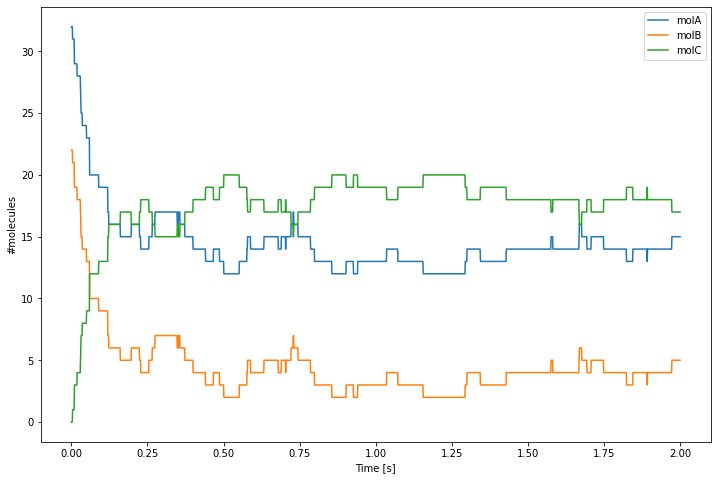

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(tpnts, values)
plt.legend(['molA', 'molB', 'molC'])
plt.xlabel('Time [s]')
plt.ylabel('#molecules')
plt.show()

## Saving data automatically

Although values can be retrieved during the simulation with simulation paths, as we just saw, STEPS implements an automatic data saving mechanism. This allows users to specify in advance which data should be saved and at which frequency. STEPS will then take care of saving the data as the simulation advances.

This automatic data saving mechanism uses the [ResultSelector](API_saving.rst#steps.API_2.saving.ResultSelector) class to declare paths to the data that should be saved. These paths work in the same way as simulation paths:

In [11]:
rs = ResultSelector(sim)

saver = rs.comp.LIST(molA, molB, molC).Count

sim.toSave(saver, dt=0.001)

we first create a `ResultSelector` object that will be used as a root of all paths. This is necessary in order to distinguish between paths like `sim.comp.molA.Count`, that should return the current number of `molA` in `comp`, and `rs.comp.molA.Count` that returns a `ResultSelector` object that represents this path.

In the above code, this `ResultSelector` object is then added to the simulation with the [toSave](API_sim.rst#steps.API_2.sim.Simulation.toSave) method. The `dt` parameter species how frequently should the data be saved. One can then call the `run` method on the simulation until the end time, the data will be saved automatically. 

If we’re using a stochastic simulation algorithm such as that implemented in solver Wmdirect, we’re usually interested in analysing the range of behaviours produced by different iterations. We can easily save data from several runs with:

In [12]:
NITER = 100

for i in range(NITER):
    sim.newRun()

    sim.comp.molA.Conc = 31.4e-6
    sim.comp.molB.Conc = 22.3e-6

    sim.run(2.0)

This basically runs `NITER` iterations of the simulation. Note that `sim.newRun()` is called at the start of each loop and the initial conditions are set before calling `sim.run` for the full 2 seconds of simulation.

## Accessing the results

We now ran all simulations and we want to access the data that was saved. 

### Saved data

We can do so from the `ResultSelector` object that we declared earlier:
```python3
saver.data[runId, timeId, colId]
```

<img src="images/saver_data_structure.png" />

`saver.data` can be seen as a numpy array with 3 dimensions (see above figure): the first dimension corresponds to the number of runs, the second to the number of saved timesteps and the last one to the number of value saved. Like for numpy arrays, the [basic slicing syntax](https://numpy.org/doc/1.18/reference/arrays.indexing.html) works (see  row / column selection on the figure).

Each time we call `sim.newRun()`, it implicitely creates a new matrix for all `ResultSelector` objects that have been linked to the simulation with the `toSave` method. Then, every `dt = 0.001`s, a new column is added to these matrices. The first two dimensions are thus straightforward to understand but the third one is a bit more tricky. In our case, we declared the saver with `saver = rs.comp.LIST(molA, molB, molC).Count`; since there are three species in the `LIST(...)` method, the third dimension has length 3. Equivalently, we could have declared a saver with:
```python
saver = sim.comp.molA.Count << sim.comp.molB.Conc << sim.comp.molC.Conc
```
We can use the `<<` operator to concatenate `sim.comp.molA.Count`, `sim.comp.molB.Conc`, and `sim.comp.molC.Conc`, each of these corresponds to a single value so the third dimension of `saver.data` will be 3 as well. If we had two compartments, we could declare a different `ResultSelector` like this:
```python
saver2 = sim.LIST(comp1, comp2).LIST(molA, molB, molC).Count
```
Which would be equivalent to:
```python
saver2 = sim.comp1.molA.Count << simp.comp1.molB.Count << sim.comp1.molC.Count << sim.comp2.molA.Count << simp.comp2.molB.Count << sim.comp2.molC.Count
```
or to
```python
saver2 = sim.comp1.LIST(molA, molB, molC).Count << sim.comp2.LIST(molA, molB, molC).Count 
```
In all of these cases, the third dimension of `saver2.data` would be 2 * 3 = 6.

### Saved time points

To get the time at which each data was saved, one can use:
```python
saver.time[runId, timeId]
```
In most cases, we will want to use `saver.time[0]` that returns a vector with all saved time points for the first run. Since we always save data at the same time, all the other runs share the same `time` vector.

In [13]:
saver.time[0]

array([0.000e+00, 1.000e-03, 2.000e-03, ..., 1.998e+00, 1.999e+00,
       2.000e+00])

### Labels

Finally, to get a string description of saved data, one can use:
```python
saver.labels
```
Since all runs share the same saved data for a given `ResultSelector`, there is no need for indexing. `saver.labels` returns a list of strings describing each saved data. For example, in our case:

In [14]:
saver.labels

['comp.molA.Count', 'comp.molB.Count', 'comp.molC.Count']


There are other possible operations for the declation of `ResultSelector` objects but they will be introduced later. 

## Plotting the results

The structure of saver.data makes it easy to plot all saved data simultaneously, to plot all saved data for run 0, one can write:

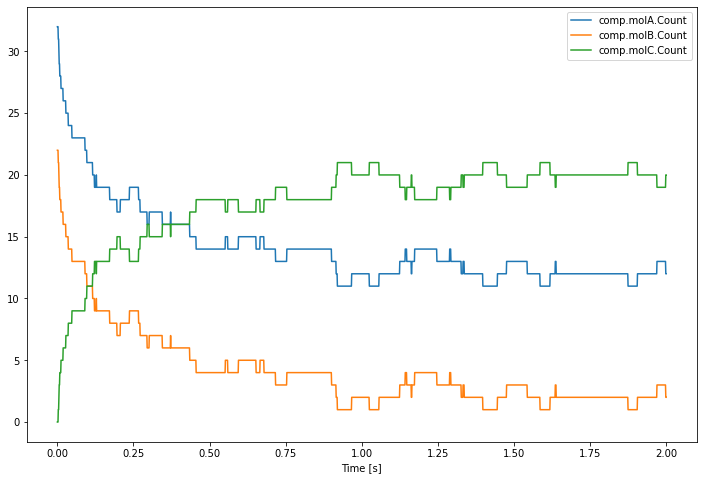

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(saver.time[0], saver.data[0])
plt.legend(saver.labels)
plt.xlabel('Time [s]')
plt.show()

If we want to look at the average across all runs, we can write:

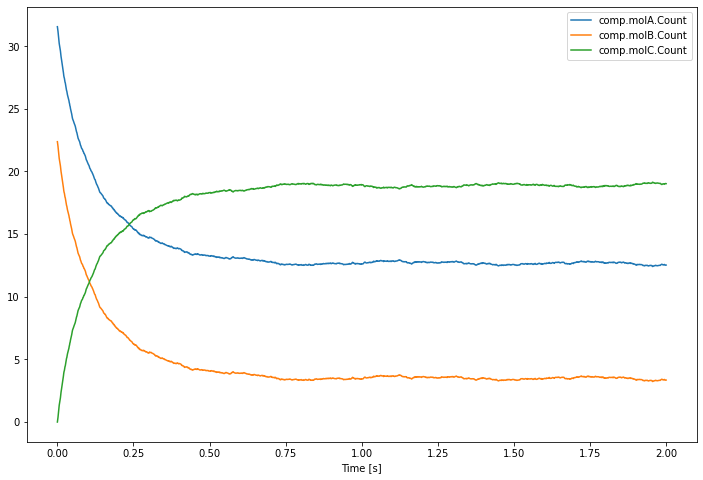

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(saver.time[0], np.mean(saver.data, axis=0))
plt.legend(saver.labels)
plt.xlabel('Time [s]')
plt.show()

`np.mean(saver.data, axis=0)` computes the average across the first dimension (`axis=0`), the one of runs.

## Controlling the simulation

In the previous section, we ran each simulation until 2s in one go, by calling `sim.run(2.0)`. The only time we actively changed the simulation state was at t=0, to set the initial conditions. However, the simulation paths calls we used to set initial conditions can be used at any time during the simulation.

As an example, let's interrupt our simulation at t=1sec to add 10 molecules of species molA. We plot the mean behaviour of multiple (n = 100) iterations of our second order reaction, with an injection of 10 molecules of species A at t = 1.0.

Newly simulated runs will simply be added to the `saver` result selector:

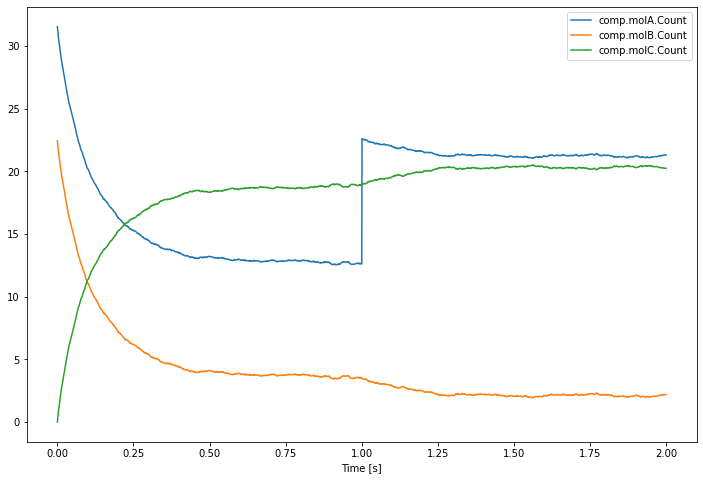

In [17]:
for i in range(NITER):
    sim.newRun()

    sim.comp.molA.Conc = 31.4e-6
    sim.comp.molB.Conc = 22.3e-6

    sim.run(1.0)

    sim.comp.molA.Count += 10

    sim.run(2.0)

plt.figure(figsize=(12, 8))
plt.plot(saver.time[0], np.mean(saver.data[NITER:], axis=0))
plt.legend(saver.labels)
plt.xlabel('Time [s]')
plt.show()

instead of `saver.data`, we use `saver.data[NITER:]` which returns the data relative to all runs whose index is higher than or equal to `NITER`.

Quite often, one does not want to simulate the sudden injection of molecules, but rather keep the concentration of some species constant at a controlled value.
This means that any reaction involving the buffered molecule will still occur if the reactants are present in sufficiently large numbers, but the occurrence of this reaction will not actually change the amount of the buffered species that is present.
The following code snippet shows how, during the time interval $0.1\leq t<0.6$, the concentration of species `molA` is clamped to whatever its value was at $t=0.5$. We plot the result of a single iteration of the second order reaction, where the concentration of A is clamped during the interval $0.1\leq t<0.6$:

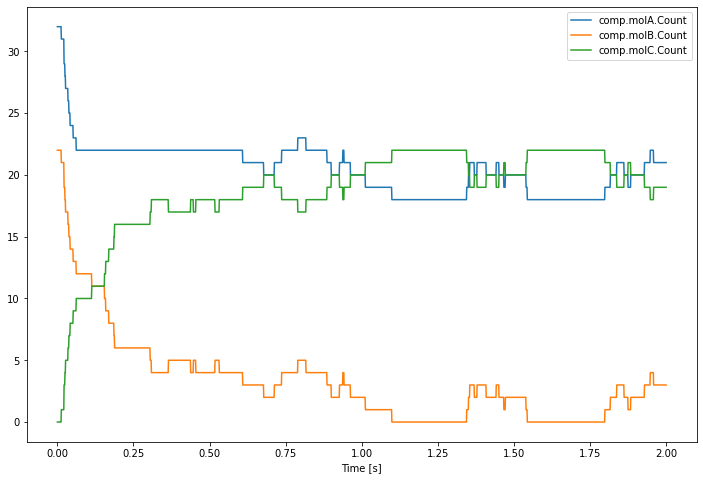

In [18]:
sim.newRun()
sim.comp.molA.Conc = 31.4e-6
sim.comp.molB.Conc = 22.3e-6

sim.run(0.1)

sim.comp.molA.Clamped = True

sim.run(0.6)

sim.comp.molA.Clamped = False

sim.run(2.0)

plt.figure(figsize=(12, 8))
plt.plot(saver.time[0], saver.data[-1])
plt.legend(saver.labels)
plt.xlabel('Time [s]')
plt.show()

`saver.data[-1]` returns the data relative to the last run. The `Clamped` property is a boolean which is used to turn on or off the clamping of the species in the specified compartment.

A final way in which we will control our simulation in this chapter is
by activating/inactivating a reaction channel. Inactivating a reaction channel
means that it will never occur, regardless of whether the required reactants
are present in sufficient numbers. In the following simulation:

* we will turn off the forward reaction of the above equation  during
  interval $2.0\leq t<4.0$;

* turn it back on and let everything recover during $4.0\leq t<6.0$;

* turn off the backward reaction during $6.0\leq t<8.0$;

* turn it back on and let everything recover again during $8.0\leq t<10.0$;

* and finally turn off both the forward and backward channel during a final
  interval $10.0\leq t<12.0$.

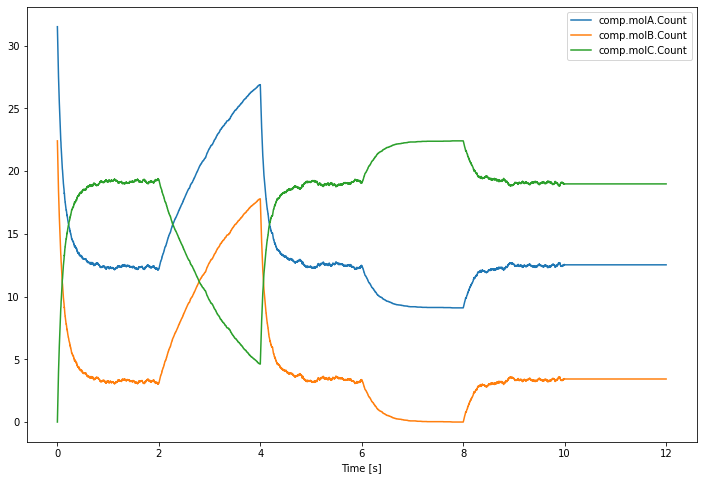

In [19]:
for i in range(NITER):
    sim.newRun()
    sim.comp.molA.Conc = 31.4e-6
    sim.comp.molB.Conc = 22.3e-6

    sim.run(2.0)

    sim.comp.r1['fwd'].Active = False
    sim.run(4.0)
    sim.comp.r1['fwd'].Active = True
    sim.run(6.0)
    sim.comp.r1['bkw'].Active = False
    sim.run(8.0)
    sim.comp.r1['bkw'].Active = True
    sim.run(10.0)
    sim.comp.r1['fwd'].Active = False
    sim.comp.r1['bkw'].Active = False
    sim.run(12.0)

plt.figure(figsize=(12, 8))
plt.plot(saver.time[-1], np.mean(saver.data[-NITER:], axis=0))
plt.legend(saver.labels)
plt.xlabel('Time [s]')
plt.show()

The `Active` property is a boolean that is available for reactions and basically turns them on or off.
Since the time points are different for these last runs, we need to take care of using `saver.time[-1]` (which returns the time points of the last run) instead of `saver.time[0]`. The data is accessed with `saver.data[-NITER:]` which returns the last `NITER` runs.